#Introduction

In this notebook, we used a network composed of 5 convolutional blocks, composed by a convolution and a pool each, plus two fully connected layers with dropout. We have done some **modification to the dataset**:


*   We split the dataset with our script in:
    *   $75$% training set
    *   $15$% validation set
    *   $10$% test set
*   We balanced the dataset with the script made by us. We set $550$ as threshold for the training set, while $250$ for the validation set. We did not change the test set.

**Augmentation**:

*   We applied data augmentation, in order to avoid overfitting due to some classes which had really few samples in them, like the Raspberry one. This helped also to "fill" a little bit the gap due to the difference of our sets and the test set on the server.

**Patience** was set to $20$, and **Learning Rate** to $0,0001$.

With this notebook we got a score of $70,75$%

#Mounting Drive

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Checking which GPU I am running on

In [ ]:
!nvidia-smi

#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

Extracting the zipped archive into the folder in which I am when I start the notebook (/content). We did this, because by extracting the zipped archive in the local folder of the runtime, speeds up a lot the first epoch in google Colab, and make its duration as shord as the following ones. This allowed us to save a lot of GPU time.

In [ ]:
!unzip /gdrive/MyDrive/AN2DL/leaves_test_overUnder_sampled.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02033.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01856.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01704.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01880.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02206.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02218.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01849.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/0_02151.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/1_01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/2_02222.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/3_01720.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/4_01745.jpg  
  inflating: leaves_test_overUnder_sampled/

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'leaves_test_overUnder_sampled' #"leaves_test" is splitted like 75% train, 15% validation, 10%test for each class. "leaves_notest" is splitted like: 80% train, 20% validation, if needed

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') #to be commented if you use the dir "_notest" (not recommended)

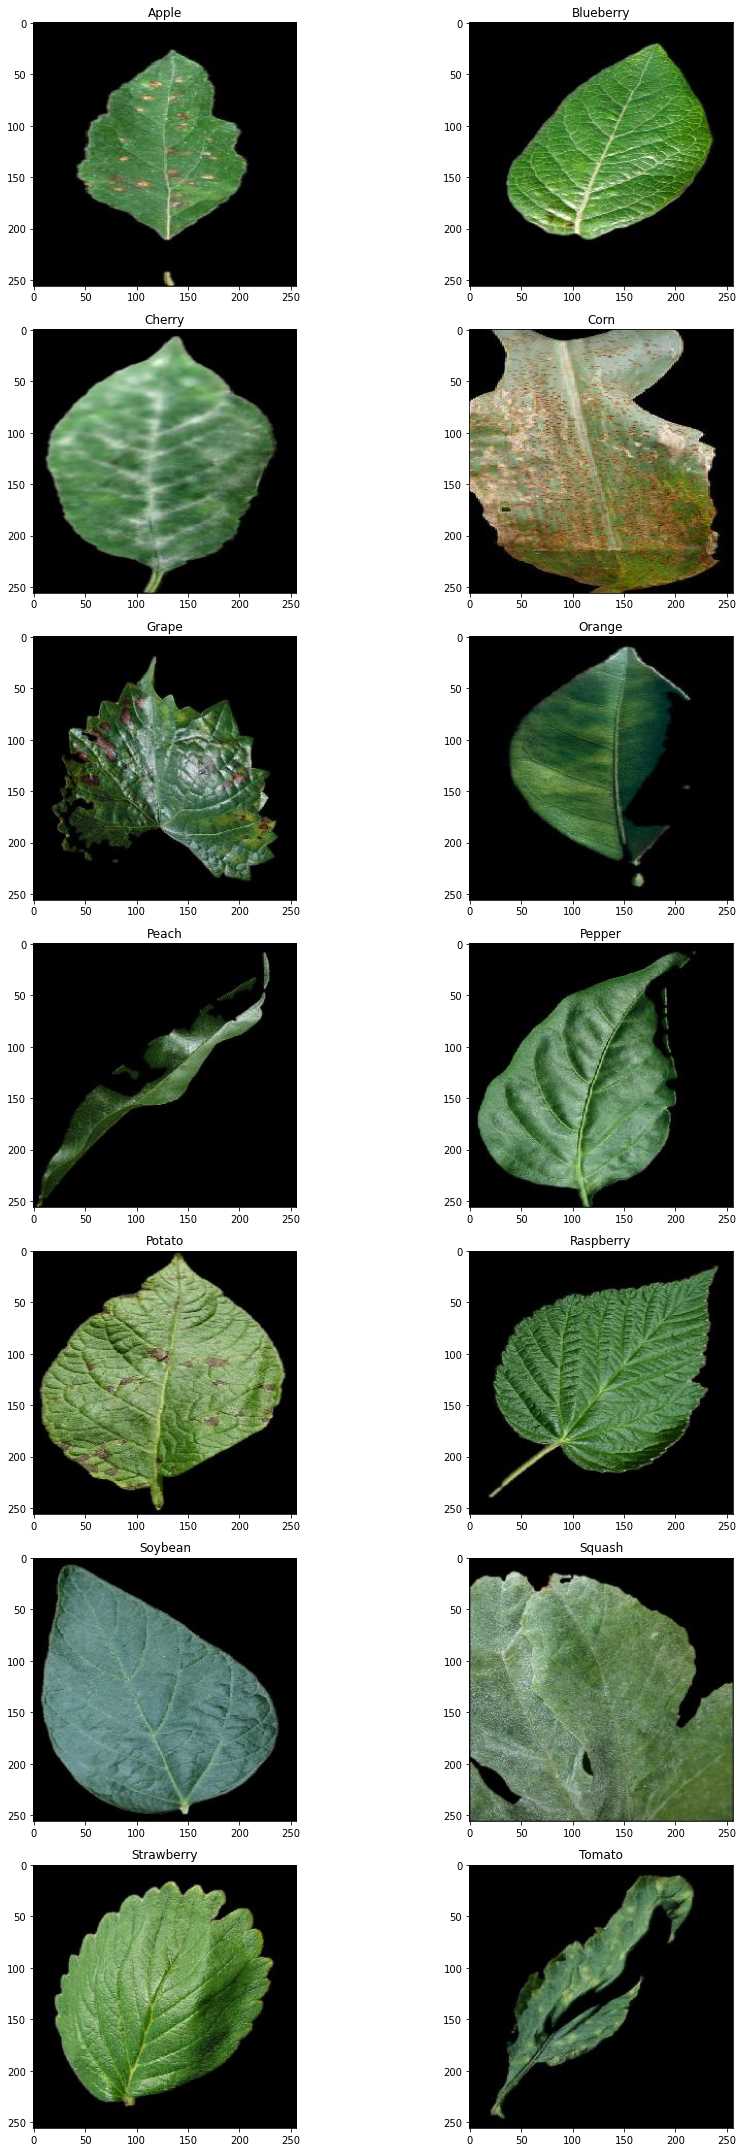

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Inspect dataset structure on disk
print("Depth 0 (leaves_test_overUnder_sampled)")
print("-------")
!ls leaves_test_overUnder_sampled
print()
print("Depth 1 (e.g., leaves_test_overUnder_sampled/training)")
print("------------------------")
!ls leaves_test_overUnder_sampled/train
print()
print("Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)")
print("----------------------------")
!ls leaves_test_overUnder_sampled/train/Blueberry

Depth 0 (leaves_test_overUnder_sampled)
-------
test  train  val

Depth 1 (e.g., leaves_test_overUnder_sampled/training)
------------------------
Apple	   Cherry  Grape   Peach   Potato     Soybean  Strawberry
Blueberry  Corn    Orange  Pepper  Raspberry  Squash   Tomato

Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)
----------------------------
0_01840.jpg  01827.jpg	02005.jpg  02190.jpg		180_02029.jpg
01647.jpg    01828.jpg	02006.jpg  02191.jpg		18_01953.jpg
01649.jpg    01829.jpg	02007.jpg  02193.jpg		181_01653.jpg
01650.jpg    01830.jpg	02008.jpg  02195.jpg		182_14_01953.jpg
01652.jpg    01831.jpg	02009.jpg  02196.jpg		183_02081.jpg
01653.jpg    01832.jpg	02012.jpg  02197.jpg		184_01996.jpg
01654.jpg    01833.jpg	02014.jpg  02198.jpg		185_01973.jpg
01655.jpg    01835.jpg	02015.jpg  02199.jpg		186_01890.jpg
01656.jpg    01837.jpg	02019.jpg  02203.jpg		187_125_02212.jpg
01657.jpg    01838.jpg	02022.jpg  02205.jpg		188_02127.jpg
01658.jpg    01840.jpg	02023.jpg  022

#Data Generator

Import:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1/255.)
aug_valid_data_gen = ImageDataGenerator(rotation_range=180, # --- N.B. --- While trying to increase performances, we tried to perform data augmentation also here, because in some classes, like the raspberry one, when we oversampled the validation set, it contained many copies. Doing some researches, we found online that, sometimes, in some specific applications, this helped a little bit and we wanted to try
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.) #to be commented if used with dataset "_notest" (not recommended)



# class_mode parameter not inserted: cathegorical (one hot coding) is the default one, hence, it is not necessary
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

aug_valid_gen = aug_valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,         #to be commented if used with dataset "_notest"
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 7700 images belonging to 14 classes.
Found 3500 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

Let's work first with the network, and then declaring callbacks and checkpoints

In [ ]:
# Model used:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

    # Return the model
    return model

Function which creates folders for callbacks

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):
  #saving checkpoints on drive. We need to change directory, hence, we need ../ to go back of on folder, from /content to /
  #N.B.: after this we don't need to go back, we did not change directory, we worked with the string of the path
  exps_dir = os.path.join('../gdrive/MyDrive/AN2DL/Checkpts/LucaA') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Building Model

In [ ]:
# Build model
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

#Training the model

In [ ]:
# Create folders and callbacks and fit
aug_bal_callbacks = create_folders_and_callbacks(model_name = 'aug_Balanced_LowLearning_MorePatience_ToSubmit') #the model name will generate the folder of this single experiment

# restore checkpoints: (uncomment if needed)
#model.load_weights('/gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_Nov20_13-25-49/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_valid_gen,
    callbacks = aug_bal_callbacks,
).history

Epoch 1/200
963/963 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9558

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 146s 135ms/step - loss: 0.1278 - accuracy: 0.9558 - val_loss: 0.1338 - val_accuracy: 0.9600
Epoch 2/200
963/963 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9596

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1246 - accuracy: 0.9596 - val_loss: 0.2222 - val_accuracy: 0.9323
Epoch 3/200
963/963 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9583

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.1297 - accuracy: 0.9583 - val_loss: 0.2037 - val_accuracy: 0.9383
Epoch 4/200
963/963 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9613

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1174 - accuracy: 0.9613 - val_loss: 0.1293 - val_accuracy: 0.9626
Epoch 5/200
963/963 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9600

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1183 - accuracy: 0.9600 - val_loss: 0.1691 - val_accuracy: 0.9397
Epoch 6/200
963/963 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9579

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.1238 - accuracy: 0.9579 - val_loss: 0.1513 - val_accuracy: 0.9497
Epoch 7/200
963/963 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9662

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1127 - accuracy: 0.9662 - val_loss: 0.1361 - val_accuracy: 0.9591
Epoch 8/200
963/963 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9623

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1171 - accuracy: 0.9623 - val_loss: 0.1555 - val_accuracy: 0.9449
Epoch 9/200
963/963 [==============================] - ETA: 0s - loss: 0.1100 - accuracy: 0.9651

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1100 - accuracy: 0.9651 - val_loss: 0.1686 - val_accuracy: 0.9480
Epoch 10/200
963/963 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9623

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.1106 - accuracy: 0.9623 - val_loss: 0.1187 - val_accuracy: 0.9611
Epoch 11/200
963/963 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9642

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.1042 - accuracy: 0.9642 - val_loss: 0.1517 - val_accuracy: 0.9531
Epoch 12/200
963/963 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9638

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.1073 - accuracy: 0.9638 - val_loss: 0.1947 - val_accuracy: 0.9409
Epoch 13/200
963/963 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9627

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.1082 - accuracy: 0.9627 - val_loss: 0.1363 - val_accuracy: 0.9563
Epoch 14/200
963/963 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9609

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.1152 - accuracy: 0.9609 - val_loss: 0.1291 - val_accuracy: 0.9580
Epoch 15/200
963/963 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9679

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1017 - accuracy: 0.9679 - val_loss: 0.1565 - val_accuracy: 0.9506
Epoch 16/200
963/963 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9656

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.0956 - accuracy: 0.9656 - val_loss: 0.1368 - val_accuracy: 0.9543
Epoch 17/200
963/963 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9634

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.1017 - accuracy: 0.9634 - val_loss: 0.1107 - val_accuracy: 0.9649
Epoch 18/200
963/963 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9670

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1005 - accuracy: 0.9670 - val_loss: 0.1217 - val_accuracy: 0.9603
Epoch 19/200
963/963 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9686

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.0987 - accuracy: 0.9686 - val_loss: 0.1349 - val_accuracy: 0.9566
Epoch 20/200
963/963 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9661

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.0958 - accuracy: 0.9661 - val_loss: 0.1452 - val_accuracy: 0.9549
Epoch 21/200
963/963 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9694

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.0954 - accuracy: 0.9694 - val_loss: 0.1632 - val_accuracy: 0.9466
Epoch 22/200
963/963 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9684

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.0949 - accuracy: 0.9684 - val_loss: 0.1184 - val_accuracy: 0.9646
Epoch 23/200
963/963 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9710

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.0905 - accuracy: 0.9710 - val_loss: 0.1315 - val_accuracy: 0.9566
Epoch 24/200
963/963 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9694

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 133ms/step - loss: 0.0889 - accuracy: 0.9694 - val_loss: 0.1812 - val_accuracy: 0.9446
Epoch 25/200
963/963 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9717

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.0873 - accuracy: 0.9717 - val_loss: 0.1231 - val_accuracy: 0.9597
Epoch 26/200
963/963 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9705

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.0902 - accuracy: 0.9705 - val_loss: 0.1791 - val_accuracy: 0.9434
Epoch 27/200
963/963 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9712

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.0873 - accuracy: 0.9712 - val_loss: 0.1420 - val_accuracy: 0.9509
Epoch 28/200
963/963 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9734

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.0808 - accuracy: 0.9734 - val_loss: 0.1574 - val_accuracy: 0.9480
Epoch 29/200
963/963 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9718

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.0836 - accuracy: 0.9718 - val_loss: 0.1030 - val_accuracy: 0.9657
Epoch 30/200
963/963 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9710

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.0823 - accuracy: 0.9710 - val_loss: 0.1509 - val_accuracy: 0.9517
Epoch 31/200
963/963 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9714

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.0886 - accuracy: 0.9714 - val_loss: 0.2848 - val_accuracy: 0.9149
Epoch 32/200
963/963 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9744

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.0790 - accuracy: 0.9744 - val_loss: 0.1555 - val_accuracy: 0.9577
Epoch 33/200
963/963 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9747

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.0770 - accuracy: 0.9747 - val_loss: 0.1255 - val_accuracy: 0.9603
Epoch 34/200
963/963 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9739

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.0802 - accuracy: 0.9739 - val_loss: 0.1120 - val_accuracy: 0.9643
Epoch 35/200
963/963 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9769

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0755 - accuracy: 0.9769 - val_loss: 0.1210 - val_accuracy: 0.9634
Epoch 36/200
963/963 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9770

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.0728 - accuracy: 0.9770 - val_loss: 0.1336 - val_accuracy: 0.9629
Epoch 37/200
963/963 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9743

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.0779 - accuracy: 0.9743 - val_loss: 0.1500 - val_accuracy: 0.9566
Epoch 38/200
963/963 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9753

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0751 - accuracy: 0.9753 - val_loss: 0.1323 - val_accuracy: 0.9586
Epoch 39/200
963/963 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9768

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0775 - accuracy: 0.9768 - val_loss: 0.1404 - val_accuracy: 0.9614
Epoch 40/200
963/963 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9801

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0607 - accuracy: 0.9801 - val_loss: 0.1191 - val_accuracy: 0.9586
Epoch 41/200
963/963 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9756

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.0712 - accuracy: 0.9756 - val_loss: 0.1119 - val_accuracy: 0.9631
Epoch 42/200
963/963 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9758

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.0747 - accuracy: 0.9758 - val_loss: 0.1393 - val_accuracy: 0.9554
Epoch 43/200
963/963 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9795

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0614 - accuracy: 0.9795 - val_loss: 0.1502 - val_accuracy: 0.9517
Epoch 44/200
963/963 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9771

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0723 - accuracy: 0.9771 - val_loss: 0.1193 - val_accuracy: 0.9626
Epoch 45/200
963/963 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9816

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 137ms/step - loss: 0.0574 - accuracy: 0.9816 - val_loss: 0.0935 - val_accuracy: 0.9700
Epoch 46/200
963/963 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9786

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0665 - accuracy: 0.9786 - val_loss: 0.1036 - val_accuracy: 0.9717
Epoch 47/200
963/963 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9756

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.0684 - accuracy: 0.9756 - val_loss: 0.1560 - val_accuracy: 0.9540
Epoch 48/200
963/963 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9801

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0617 - accuracy: 0.9801 - val_loss: 0.1046 - val_accuracy: 0.9723
Epoch 49/200
963/963 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9812

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0587 - accuracy: 0.9812 - val_loss: 0.1307 - val_accuracy: 0.9600
Epoch 50/200
963/963 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9773

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 137ms/step - loss: 0.0716 - accuracy: 0.9773 - val_loss: 0.0990 - val_accuracy: 0.9691
Epoch 51/200
963/963 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9795

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0600 - accuracy: 0.9795 - val_loss: 0.2420 - val_accuracy: 0.9331
Epoch 52/200
963/963 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9790

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 137ms/step - loss: 0.0631 - accuracy: 0.9790 - val_loss: 0.1443 - val_accuracy: 0.9580
Epoch 53/200
963/963 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9801

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0556 - accuracy: 0.9801 - val_loss: 0.1121 - val_accuracy: 0.9674
Epoch 54/200
963/963 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9781

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0678 - accuracy: 0.9781 - val_loss: 0.1470 - val_accuracy: 0.9557
Epoch 55/200
963/963 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9825

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0553 - accuracy: 0.9825 - val_loss: 0.0897 - val_accuracy: 0.9731
Epoch 56/200
963/963 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9813

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0562 - accuracy: 0.9813 - val_loss: 0.1443 - val_accuracy: 0.9640
Epoch 57/200
963/963 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9787

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0657 - accuracy: 0.9787 - val_loss: 0.1363 - val_accuracy: 0.9569
Epoch 58/200
963/963 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9835

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0480 - accuracy: 0.9835 - val_loss: 0.1651 - val_accuracy: 0.9506
Epoch 59/200
963/963 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9792

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1200 - val_accuracy: 0.9666
Epoch 60/200
963/963 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9819

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0538 - accuracy: 0.9819 - val_loss: 0.1499 - val_accuracy: 0.9563
Epoch 61/200
963/963 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9779

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 137ms/step - loss: 0.0572 - accuracy: 0.9779 - val_loss: 0.1056 - val_accuracy: 0.9709
Epoch 62/200
963/963 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9826

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0529 - accuracy: 0.9826 - val_loss: 0.1679 - val_accuracy: 0.9506
Epoch 63/200
963/963 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9814

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 137ms/step - loss: 0.0564 - accuracy: 0.9814 - val_loss: 0.1442 - val_accuracy: 0.9626
Epoch 64/200
963/963 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9822

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 137ms/step - loss: 0.0540 - accuracy: 0.9822 - val_loss: 0.1742 - val_accuracy: 0.9483
Epoch 65/200
963/963 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9803

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.0645 - accuracy: 0.9803 - val_loss: 0.1318 - val_accuracy: 0.9580
Epoch 66/200
963/963 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9844

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 137ms/step - loss: 0.0488 - accuracy: 0.9844 - val_loss: 0.1294 - val_accuracy: 0.9643
Epoch 67/200
963/963 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9829

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.0582 - accuracy: 0.9829 - val_loss: 0.1289 - val_accuracy: 0.9669
Epoch 68/200
963/963 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9840

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.0475 - accuracy: 0.9840 - val_loss: 0.1165 - val_accuracy: 0.9649
Epoch 69/200
963/963 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9818

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0589 - accuracy: 0.9818 - val_loss: 0.1356 - val_accuracy: 0.9631
Epoch 70/200
963/963 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9829

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0507 - accuracy: 0.9829 - val_loss: 0.1467 - val_accuracy: 0.9583
Epoch 71/200
963/963 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9865

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 137ms/step - loss: 0.0439 - accuracy: 0.9865 - val_loss: 0.1176 - val_accuracy: 0.9646
Epoch 72/200
963/963 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9818

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 137ms/step - loss: 0.0524 - accuracy: 0.9818 - val_loss: 0.1250 - val_accuracy: 0.9674
Epoch 73/200
963/963 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9832

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0529 - accuracy: 0.9832 - val_loss: 0.1310 - val_accuracy: 0.9657
Epoch 74/200
963/963 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9849

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.0486 - accuracy: 0.9849 - val_loss: 0.0902 - val_accuracy: 0.9731
Epoch 75/200
963/963 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9852

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_Balanced_LowLearning_MorePatience_ToSubmit_Nov21_15-41-23/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 137ms/step - loss: 0.0489 - accuracy: 0.9852 - val_loss: 0.1563 - val_accuracy: 0.9531


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/AN2DL/models

/gdrive/MyDrive/AN2DL/models


In [ ]:
# Save best epoch model
model.save("Models/LucaA/aug_Balanced_LowLearning_MorePatience_TOSUBMIT_TRUE")

INFO:tensorflow:Assets written to: Models/LucaA/aug_Balanced_LowLearning_MorePatience_TOSUBMIT_TRUE/assets


INFO:tensorflow:Assets written to: Models/LucaA/aug_Balanced_LowLearning_MorePatience_TOSUBMIT_TRUE/assets


#Plot training error and validation error

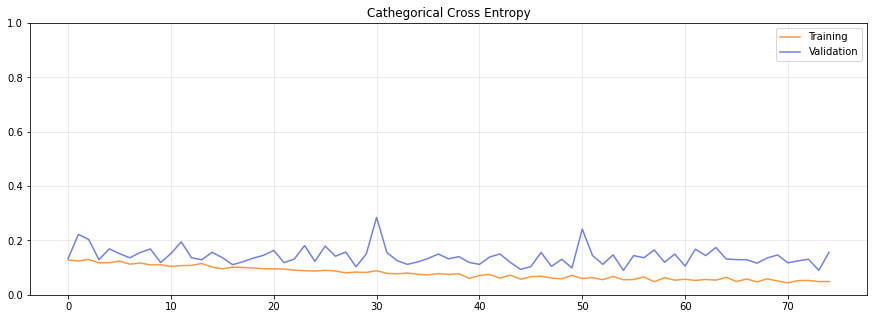

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2') # "Val because it is on validation set"
plt.ylim(0, 1)
plt.title('Cathegorical Cross Entropy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Testing
N.B.: this cells can be executed only if considering the dataset with the test folder (reccommend to use the dataset with the test folder)

In [ ]:
cd /content

/content


In [ ]:
model_to_be_tested = tfk.models.load_model("../gdrive/MyDrive/AN2DL/models/Models/LucaA/aug_Balanced_LowLearning_MorePatience_TOSUBMIT_TRUE")
model_to_be_tested_metrics = model_to_be_tested.evaluate(test_gen, return_dict=True)

224/224 [==============================] - 4s 18ms/step - loss: 0.2583 - accuracy: 0.9417


#Further informations on testing

##Printing Activations

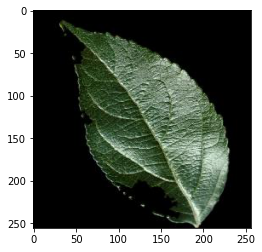

In [ ]:
# Get sample batch
batch = next(test_gen)[0]

# Get first image
image = batch[3] # batch size = 8

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

In [ ]:
# Get the activations (the output of each ReLU layer)
# We can do it by creating a new Model (activation_model) with the same input as 
# the original model and all the ReLU activations as output
layers = [layer.output for layer in model_to_be_tested.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=model_to_be_tested.input, outputs=layers)
# Finally we get the output feature maps (for each layer) given the imput test image
fmaps = activation_model.predict(tf.expand_dims(image, 0))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1): 
    # fmaps: list of all the feature maps for each layer
    # depth: the layer we want to visualize (an int in [0, network depth))
    # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

    fmaps = fmaps[depth] # get feature maps at the desired depth
    if first_n > 0:
      fmaps = fmaps[0, :, :, :first_n] 
    fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

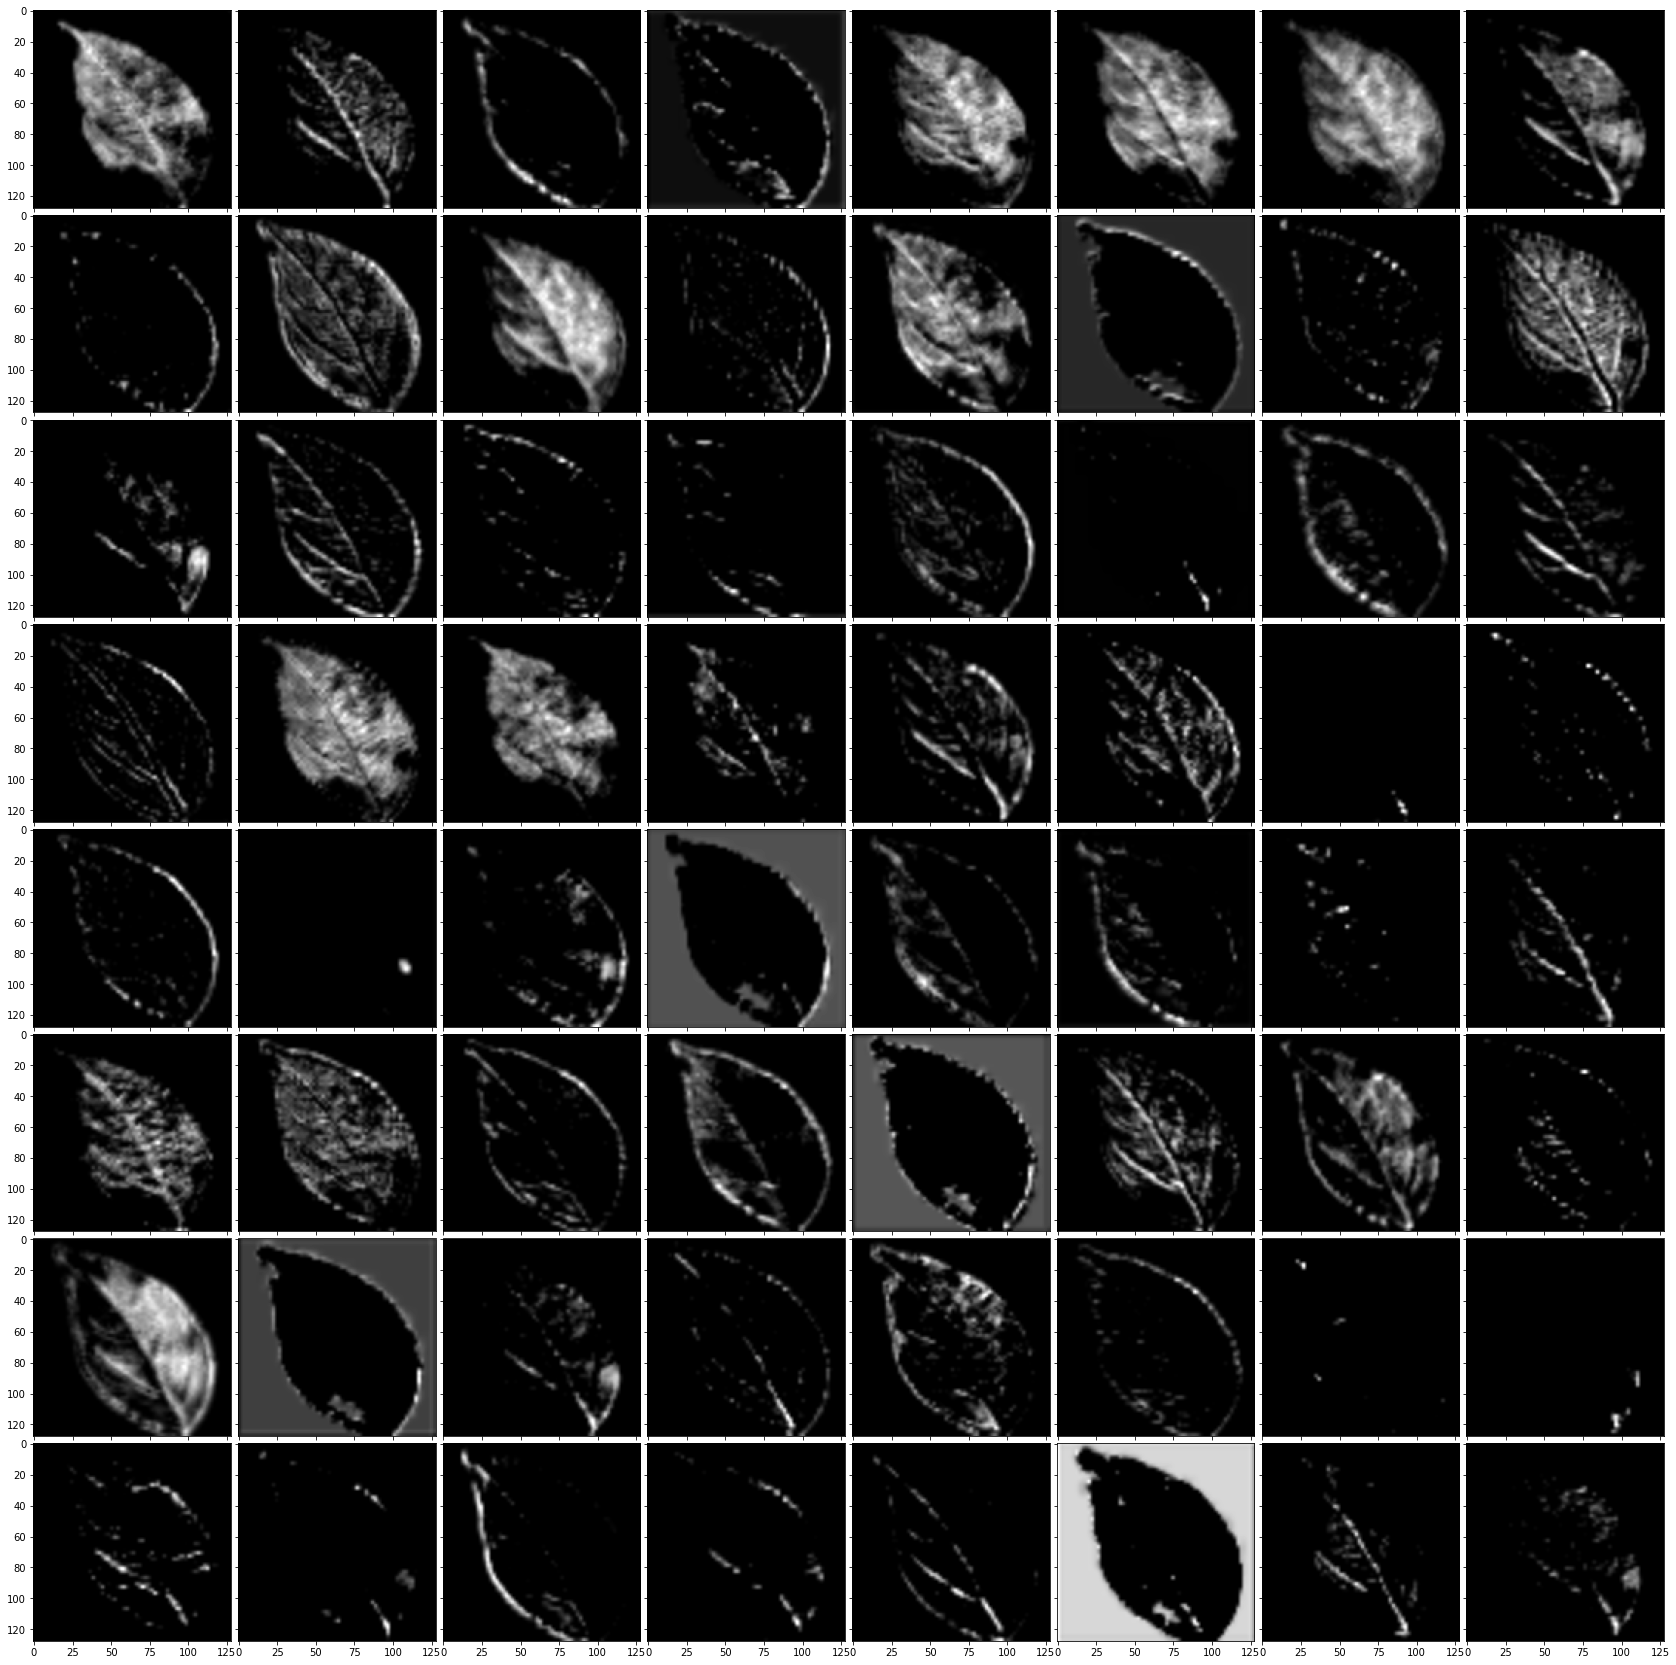

In [ ]:
display_activation(fmaps=fmaps, depth=2, first_n=-1)

##Confusion Matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Accuracy: 0.9417
Precision: 0.9293
Recall: 0.967
F1: 0.9457


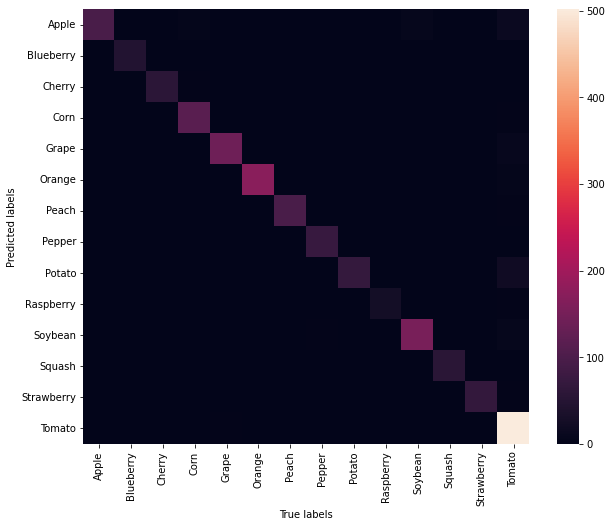

In [ ]:
predictions = model_to_be_tested.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()